In [62]:
import argparse
import logging
from pathlib import Path
from typing import Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import (
    calculate_weights,
    get_available_trackers,
    load_trackers,
    get_rebalance_dates,
    cap_long_only_weights,
    calc_covariance,
    cov_to_vols,
)
from backtest import backtest2
from entities import FX_TRACKER_DICT, EM_CDS_TRACKER_DICT

from bwlogger import StyleAdapter, basic_setup
from bwutils import open_file
from portfolio.construction import calculate_weights as calculate_weights_fh

# testing

In [88]:
from run_backtest import trackers

trackers.columns.sort_values()
BRL
CLP
CNY
COP
IDR
MXN
RUB
TRY
ZAR

NameError: name 'BRL' is not defined

In [84]:
ccy = "BRL"

def get_pairs(ccy: str, long_class: Literal["cds", "fx"]):
    short_class = "fx" if long_class == "cds" else "cds"
    df = trackers.filter(like=ccy).copy().dropna()
    long = df.filter(like=long_class).iloc[:, 0]
    short = df.filter(like=short_class).iloc[:, 0]
    short = (short**-1) * short.iloc[0] * 100
    long = long / long.iloc[0] * 100
    return long.rename(f"long_{long.name}"), short.rename(f"short_{short.name}")

long, short = get_pairs("BRL", "cds")

short


date
2007-08-07    100.000000
2007-08-08     98.723547
2007-08-09    100.100246
2007-08-10    102.488878
2007-08-13    101.603435
                 ...    
2024-08-27     91.975839
2024-08-28     92.466282
2024-08-29     94.317938
2024-08-30     94.685989
2024-09-03     94.210757
Name: short_BRL_fx, Length: 4291, dtype: float64

date
2007-08-07    100.000000
2007-08-08     98.723547
2007-08-09    100.100246
2007-08-10    102.488878
2007-08-13    101.603435
                 ...    
2024-08-27     91.975839
2024-08-28     92.466282
2024-08-29     94.317938
2024-08-30     94.685989
2024-09-03     94.210757
Name: short_BRL_fx, Length: 4291, dtype: float64

In [59]:
long = trackers_ew.iloc[:, 1]
short = trackers_ew.iloc[:, 0]
long_return = np.log(long).diff(21)
short_return = np.log(short).diff(21)
pd.Series(
    {long.name: 1, short.name: -long_return.cov(short_return) / short_return.var()}
)

L-CDS-EW    1.000000
L-FX-EW    -0.602032
dtype: float64

date
2010-09-09         NaN
2010-09-10    0.001599
2010-09-13    0.005305
2010-09-14    0.007047
2010-09-15    0.009441
                ...   
2024-08-20    0.324665
2024-08-21    0.324479
2024-08-22    0.323204
2024-08-23    0.325373
2024-08-27    0.326920
Name: L-CDS-EW, Length: 3428, dtype: float64

# Plot

In [9]:
FOLDER = Path(
    "C:/Users/pcampos/OneDrive - Insper - Instituto de Ensino e Pesquisa/Dissertação Mestrado/Analysis/backtests"
)
list_series = []

In [12]:
file_paths = list(FOLDER.glob("*.xlsx"))

In [105]:
def read_files_backtest(pattern: str) -> pd.DataFrame:
    list_series = []
    for file_path in FOLDER.glob(pattern):
        s_backtest = pd.read_excel(file_path, index_col=0)["backtest"]
        s_backtest.name = file_path.stem
        list_series.append(s_backtest)
    df_backtest = pd.concat(list_series, axis=1).sort_index()
    return df_backtest


read_files("LS-CDS_FX-IV-*.xlsx")

,LS-CDS_FX-IV-BRL,LS-CDS_FX-IV-CLP,LS-CDS_FX-IV-COP,LS-CDS_FX-IV-IDR,LS-CDS_FX-IV-MXN,LS-CDS_FX-IV-RUB,LS-CDS_FX-IV-TRY,LS-CDS_FX-IV-ZAR
date,,,,,,,,
2007-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-08-28,327.793193,225.759566,270.739249,161.715294,191.731949,NaN,547.975483,359.502097
2024-08-29,332.571042,227.325614,273.270818,160.257561,194.916112,NaN,546.666924,358.611682
2024-08-30,332.092136,226.888225,274.962767,161.336409,192.308213,NaN,545.570743,358.925751


In [106]:
FOLDER = Path(
    "C:/Users/pcampos/OneDrive - Insper - Instituto de Ensino e Pesquisa/Dissertação Mestrado/Analysis/backtests"
)


list_series = []


for file_path in FOLDER.glob("*.xlsx"):


    s_backtest = pd.read_excel(file_path, index_col=0)["backtest"]


    s_backtest.name = file_path.stem

    list_series.append(s_backtest)


df_backtest = pd.concat(list_series, axis=1)

C:\Users\pcampos\AppData\Local\Temp\ipykernel_30388\822336325.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(
C:\Users\pcampos\AppData\Local\Temp\ipykernel_30388\822336325.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(


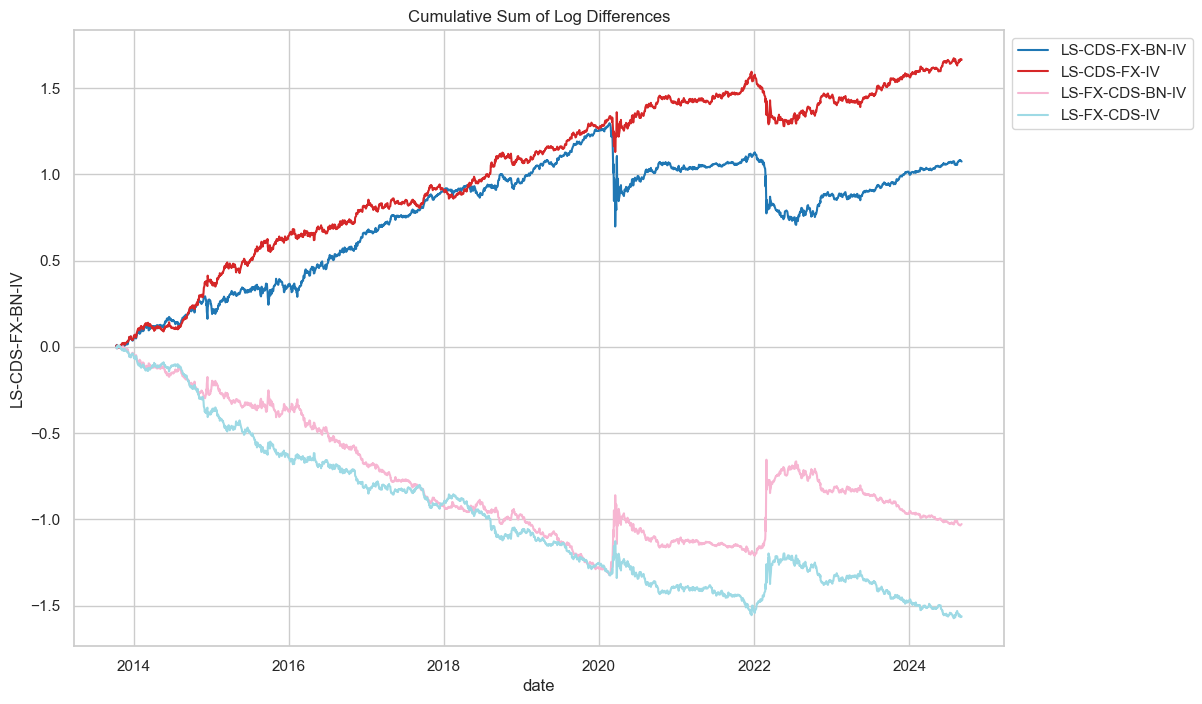

In [107]:
import seaborn as sns
# Assuming df_backtest is already defined
sns.set(style="whitegrid")
data = (
    np.log(df_backtest.dropna(how="any"))
    .diff(1)
    .cumsum()
)
# Create the plot
colors = plt.cm.get_cmap(
    "tab20", len(data.columns)
)  # Get a colormap with enough colors

# Create the plot
plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap(
    "tab20", len(data.columns)
)  # Get a colormap with enough colors

for i, column in enumerate(data.columns):
    sns.lineplot(data=data[column], color=colors(i), label=column)

# Add legend and display the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Cumulative Sum of Log Differences")
plt.show()